In [19]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import auc, roc_curve, average_precision_score, roc_auc_score, silhouette_score, silhouette_samples

In [98]:
# source 
data = loadmat('annthyroid.mat')

In [99]:
#data

In [100]:
X = data['X']
y = data['y']

In [101]:
y = np.concatenate(y).tolist()

In [230]:
print('Labels in Truth: ' + str(np.unique(y)))

Labels in Truth: [0 1]


2.1: Use KMeans, Agglomerative Clustering and DBSCAN to cluster the data. For each
algorithm, try to manually tune the parameters for a reasonable outcome and document how
you tuned the parameters. In particular pay attention to the sizes of the clusters created.
Create a dendrogram for agglomerative clustering (the truncate_mode='level' might be useful).
Manually inspect the outcomes as good as you can and identify if any of the resulting clusters
are semantically meaningful (as far as you can tell).

In [16]:
mat = loadmat('annthyroid.mat')
y = pd.DataFrame(mat['y'])[0]
X = pd.DataFrame(mat['X'])

In [24]:
def silhouette_plot(X, cluster_labels, ax=None):
    silhouette_scores = silhouette_samples(X, cluster_labels)
    if ax is None:
        ax = plt.gca()
    y_lower = 10
    inliers = cluster_labels != -1
    X = X[inliers]
    cluster_labels = cluster_labels[inliers]
    silhouette_scores = silhouette_scores[inliers]
    labels = np.unique(cluster_labels)
    cm = plt.cm.Vega10 if len(labels) <= 10 else plt.cm.Vega20
    for i in labels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm(i)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

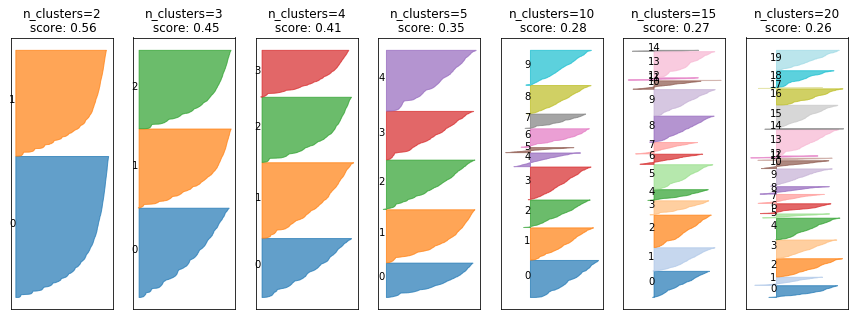

In [25]:
fig, axes = plt.subplots(1, 7, subplot_kw={'xticks': (), 'yticks':()}, figsize=(15, 5))
for ax, n_clusters in zip(axes, [2, 3, 4, 5, 10, 15, 20]):
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    silhouette_plot(X, km.labels_, ax=ax)
    ax.set_title("n_clusters={}\n score: {:.2f}".format(n_clusters, silhouette_score(X, km.labels_)))
plt.show()

In [26]:
#Kmeans
optimal_center = 2

km = KMeans(n_clusters = optimal_center, random_state=0)
km.fit(X)
#print(km.cluster_centers_.shape)
#print(km.labels_.shape)
y_kmeans = km.predict(X)
#print(y_kmeans)


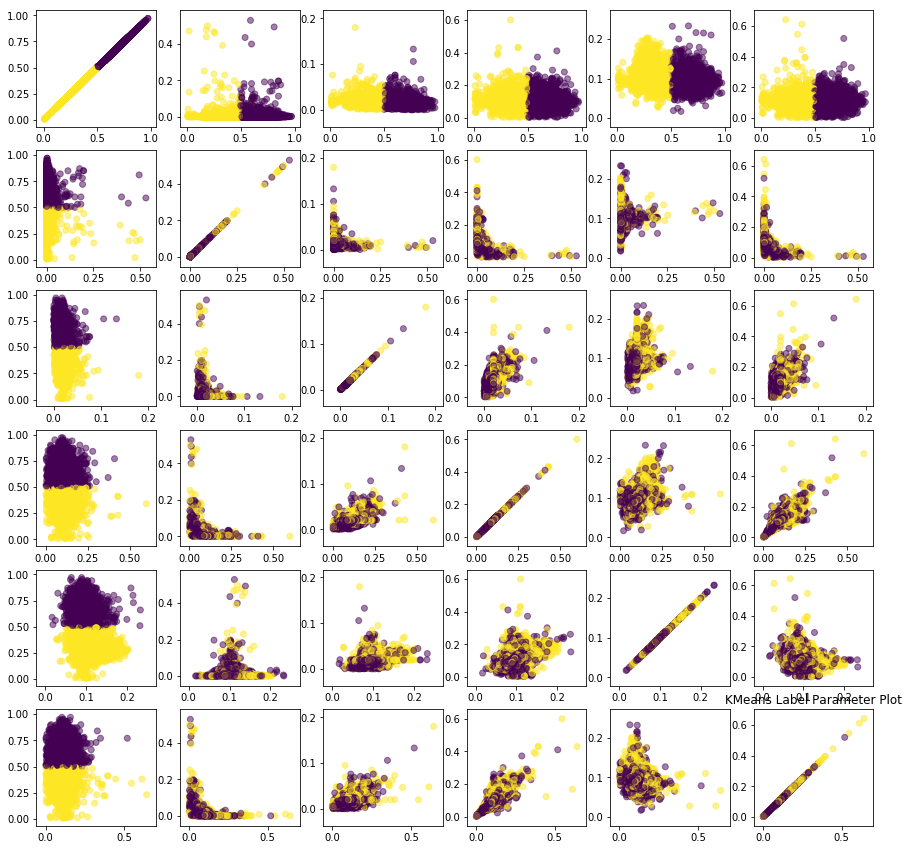

In [29]:
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[i], X[j], c= km.labels_, alpha = 0.5)
plt.title('KMeans Label Parameter Plot')
plt.show()

In [30]:
# Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters = optimal_center,
                            linkage = 'ward')
ac.fit(X)
y_ac = ac.labels_

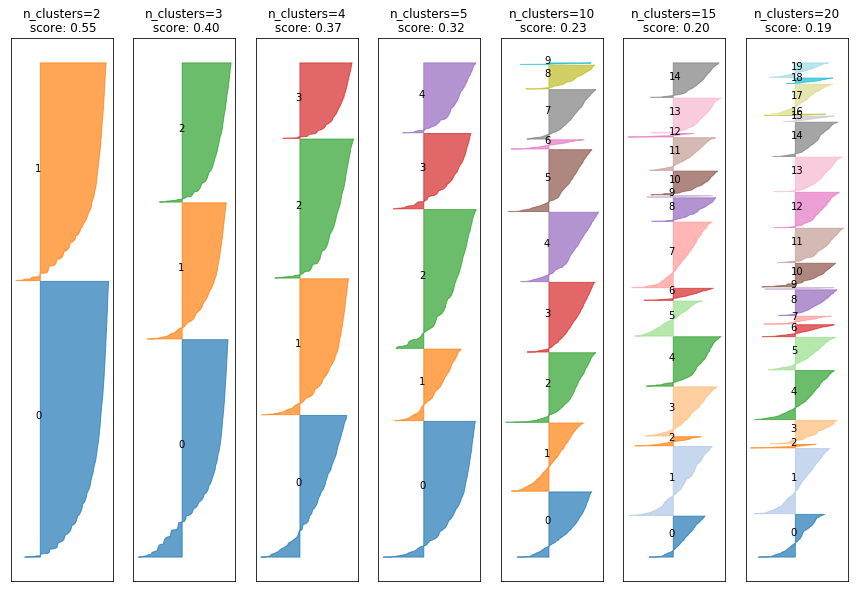

In [202]:
fig, axes = plt.subplots(1, 7, subplot_kw={'xticks': (), 'yticks':()}, figsize=(15, 10))
for ax, n_clusters in zip(axes, [2, 3, 4, 5, 10, 15, 20]):
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    ac.fit(X)
    silhouette_plot(X, ac.labels_, ax=ax)
    ax.set_title("n_clusters={}\n score: {:.2f}".format(n_clusters, silhouette_score(X, ac.labels_)))

In [233]:
optimal_center = 2
ac = AgglomerativeClustering(n_clusters = optimal_center,
                            linkage = 'ward')
ac.fit(X)
y_ac = ac.labels_
#print(ac.n_components_)

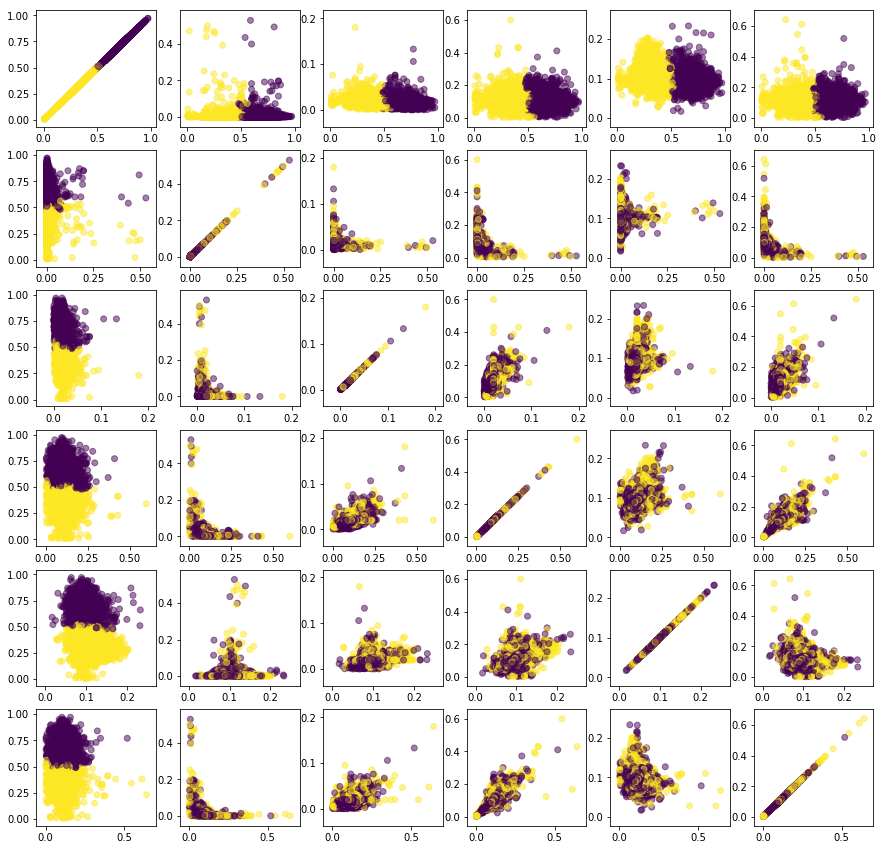

In [234]:
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:, i], X[:, j], c=ac.labels_, alpha = 0.5)


In [204]:
Z = linkage(X, 'ward')

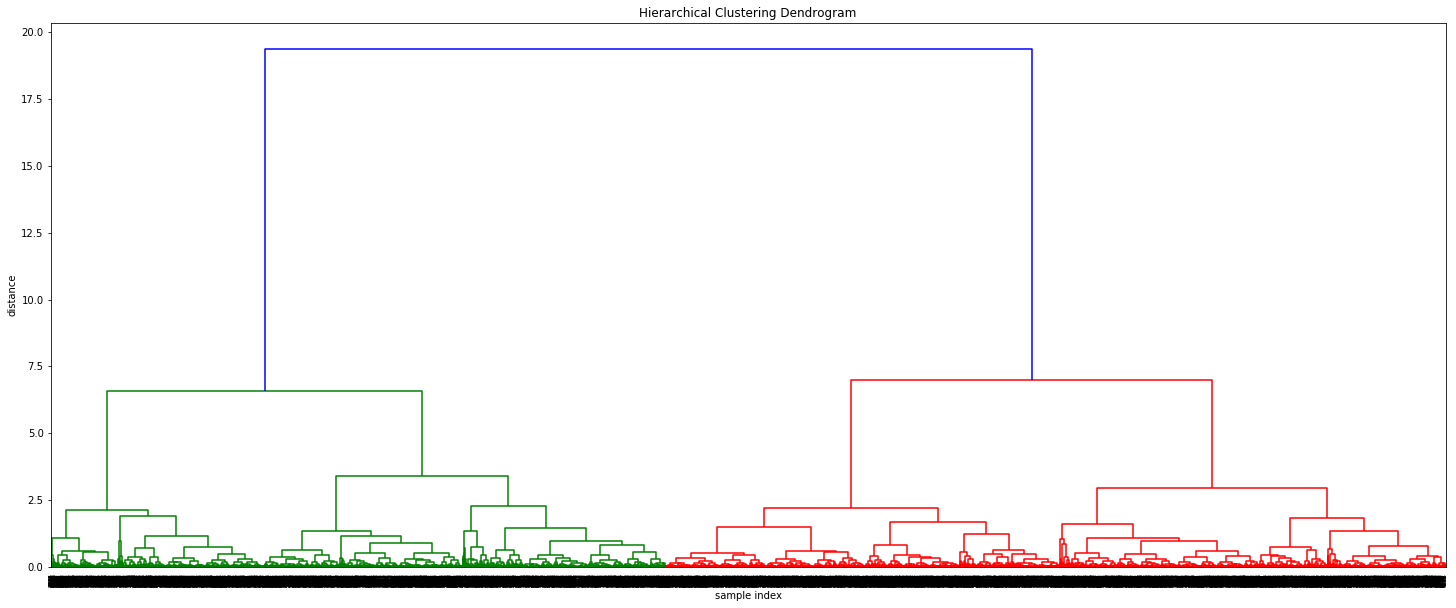

In [205]:
# calculate full dendrogram
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='level')
plt.show()

In [259]:
#DBSCAN 
db = DBSCAN(eps=0.1, min_samples=30, metric='euclidean')
db.fit(X)
y_db = db.labels_
plt.show()

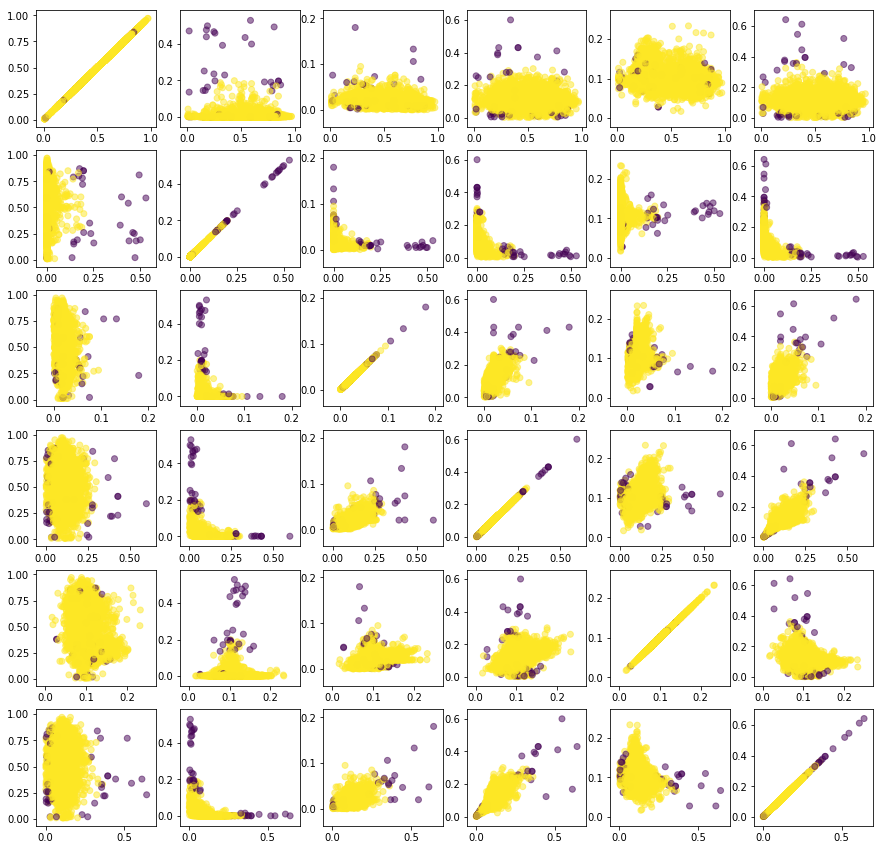

In [249]:
db = DBSCAN(eps=0.1, min_samples=20, metric='euclidean')
db.fit(X)
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:, i], X[:, j], c=db.labels_, alpha = 0.5)
plt.show()

From building a Silhouette Plot in Kmeans and agglomerative clustering, we get the largest silhouette score at n_cluster = 2. Afterwards, we manually tune various cluster numbers and plot a 6 by 6 plot, plotting all combinations of parameter by parameter, we can see that the data is linearly separable in KMeans and Agglomerative Clustering with the first parameter. Based on each cluster, we can see that this method may be questionable because the cluster sizes generally changes to 1/n of the size given that cluster_n = n. This means that the cluster size is largely dependent on how many clusters we define and not by the actual data. 

Since we've decided to use n_cluster = 2, we've tuned the DBSCAN to show two clusters as well. Parameters of epsilon = 0.1 and min_samples = 30 gave us that result. (I've tried to tune min_samples to a bigger number so one of the classes captures more samples). In DBSCAN, cluster sizes are very different for the two classes. 

Based on the cluster sizes, it seems like Kmeans and Agglomerative Clustering cannot differentiate the classes since the cluster sizes changes to 1/n as n_clusters increases. DBSCAN seems to do a better job because it can pick out points that are not close to the main cluster, as shown in the purple color.

2.2: Use the known ground truth labels of the outlier vs inlier class to evaluate your clustering approaches using NMI and ARI scores. How well did they do? Can you adjust parameters so they can detect the outliers better? 

In [260]:
#NMI
print('K-Means:')
print(normalized_mutual_info_score(y, y_kmeans))
print('Agglomerative Clusters:')
print(normalized_mutual_info_score(y, y_ac))
print('DBSCAN:')
print(normalized_mutual_info_score(y, y_db))


K-Means:
0.003732234107965867
Agglomerative Clusters:
0.0017198726898244392
DBSCAN:
0.05506721173020547


In [261]:
#ARI
print('K-Means:')
print(adjusted_rand_score(y, y_kmeans))
print('Agglomerative Clusters:')
print(adjusted_rand_score(y, y_ac))
print('DBSCAN:')
print(adjusted_rand_score(y, y_db))

K-Means:
-0.006303057143273192
Agglomerative Clusters:
-0.0036439041784818564
DBSCAN:
0.08002078792331771


In [215]:
kmeans_nmi = []
kmeans_ari = []
for i in range(1, 20):
    km = KMeans(n_clusters = i, random_state=0)
    km.fit(X)
    y_kmeans = km.predict(X)
    kmeans_nmi.append(normalized_mutual_info_score(y, y_kmeans))
    kmeans_ari.append(adjusted_rand_score(y, y_kmeans))

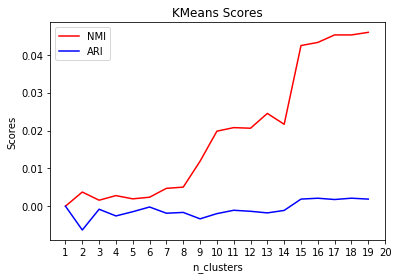

In [238]:
axis = np.arange(1, 20, 1)
plt.plot(axis, kmeans_nmi, 'r', label ='NMI')
plt.plot(axis, kmeans_ari,'b', label = 'ARI')
plt.xlabel('n_clusters')
plt.ylabel('Scores')
plt.title('KMeans Scores')
plt.legend()
plt.xticks(np.arange(1, 21, 1.0))
plt.show()

In [217]:
ac_nmi = []
ac_ari = []
for i in range(1, 20):
    ac = AgglomerativeClustering(n_clusters = i, linkage = 'ward')
    ac.fit(X)
    y_ac = ac.labels_
    ac_nmi.append(normalized_mutual_info_score(y, y_ac))
    ac_ari.append(adjusted_rand_score(y, y_ac))

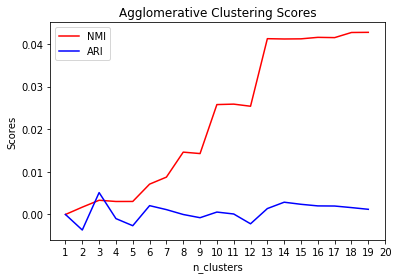

In [240]:
plt.plot(axis, ac_nmi, 'r', label ='NMI')
plt.plot(axis, ac_ari,'b', label = 'ARI')
plt.xlabel('n_clusters')
plt.ylabel('Scores')
plt.title('Agglomerative Clustering Scores')
plt.legend()
plt.xticks(np.arange(1, 21, 1.0))
plt.show()

In [219]:
# NMI too high is overfitting. ARI is probably best at n_cluster = 2

In [264]:
db_nmi = []
db_ari = []
axis = np.arange(0.1, 2.1, 0.1)
for i in range(0, 20):
    db = DBSCAN(eps=axis[i], min_samples=30, metric='euclidean')
    db.fit(X)
    y_db = db.labels_
    db_nmi.append(normalized_mutual_info_score(y, y_db))
    db_ari.append(adjusted_rand_score(y, y_db))

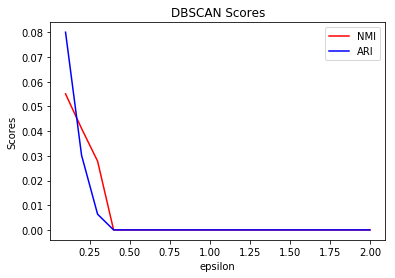

In [265]:
plt.plot(axis, db_nmi, 'r', label ='NMI')
plt.plot(axis, db_ari,'b', label = 'ARI')
plt.xlabel('epsilon')
plt.ylabel('Scores')
plt.title('DBSCAN Scores')
plt.legend()
plt.show()
plt.show()

Based on setting cluster number into two, the NMI and ARI numbers are horrible. Similar to my conjecture, Kmeans and Agglomerative Clustering number were very bad (<0.01) for NMI and and negative for ARI. DBSCAN is only marginally better at 0.05 and 0.08, respectively. 

Therefore, I've decided to plot NMI and ARI scores based on different n_clusters sizes for Kmeans and Agglomerative Clustering. I'm tuning the epsilon at min_sample = 30 for DBSCAN. 

Yes, we can adjust the parameter to make the scores better. Based on KMeans, ARI scores seem to be fairly constant regardless on how many clusters there are, but is marginally better at n_clusters = 3. N_clusters = 3 might have been a slightly better choice. NMI scores continually to increase as the number of clusters increase. However, this may be a result of overfitting. Similar result is seen in Agglomerative Clustering, and the n_clusters = 3 may have been a better choice. 

DBSCAN has a unamimous result for NMI and ARI such that they both prefer a lower epsilon. Therefore, I would have stuck with the epsilon = 0.1.



3.1 Assume that you know the proportion of outliers. Use EllipticEnvelope,
OneClassSVM and IsolationForest to detect outliers. Without using the ground-truth, can you
tell which one gave the best results? Why?

In [266]:
#Elliptic Envelope
ee = EllipticEnvelope(contamination=.1).fit(X)

pred_ee = ee.predict(X)
print(pred_ee)
#print(np.unique(pred_ee))
#print(np.mean(pred_ee == -1))

[1 1 1 ... 1 1 1]


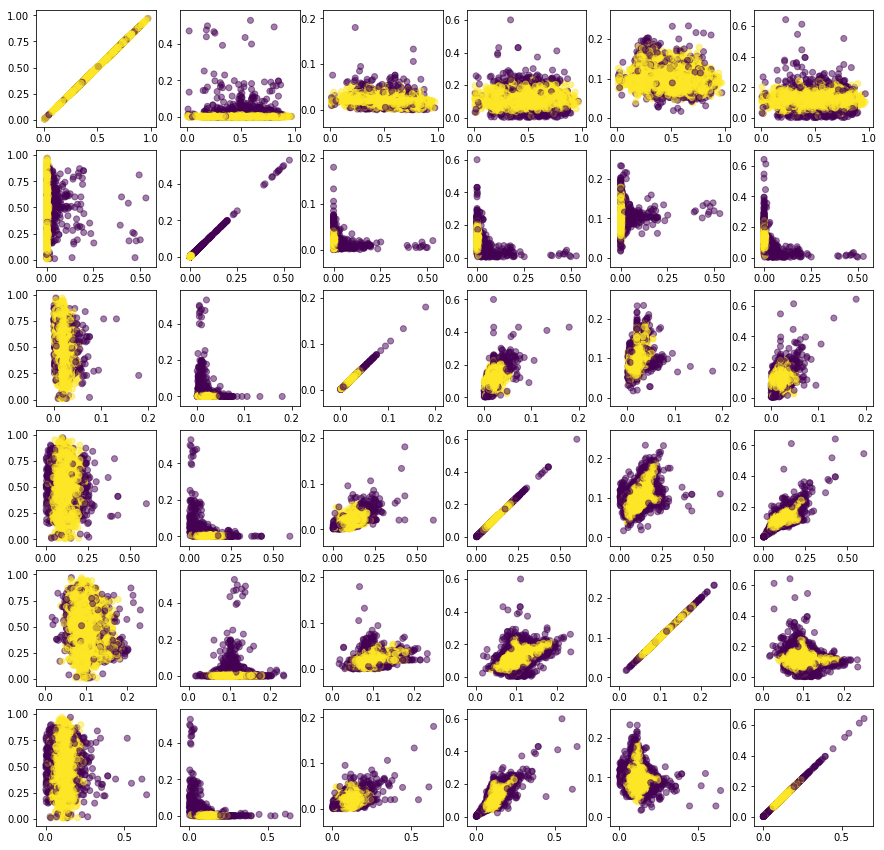

In [273]:
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:,i], X[:, j], c=pred_ee, alpha = 0.5)
        #plt.gca().set_aspect("equal")
#plt.title('Cluster Label based on Elliptic Envelope')
plt.show()

In [126]:
# OneClassSVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
oneclass = OneClassSVM(nu=.1).fit(X_scaled)
pred_oc = oneclass.predict(X_scaled)
print(pred_oc)
#print(np.unique(pred_oc))
#print(np.mean(pred_oc == -1))

[1 1 1 ... 1 1 1]
[-1  1]
0.09986111111111111


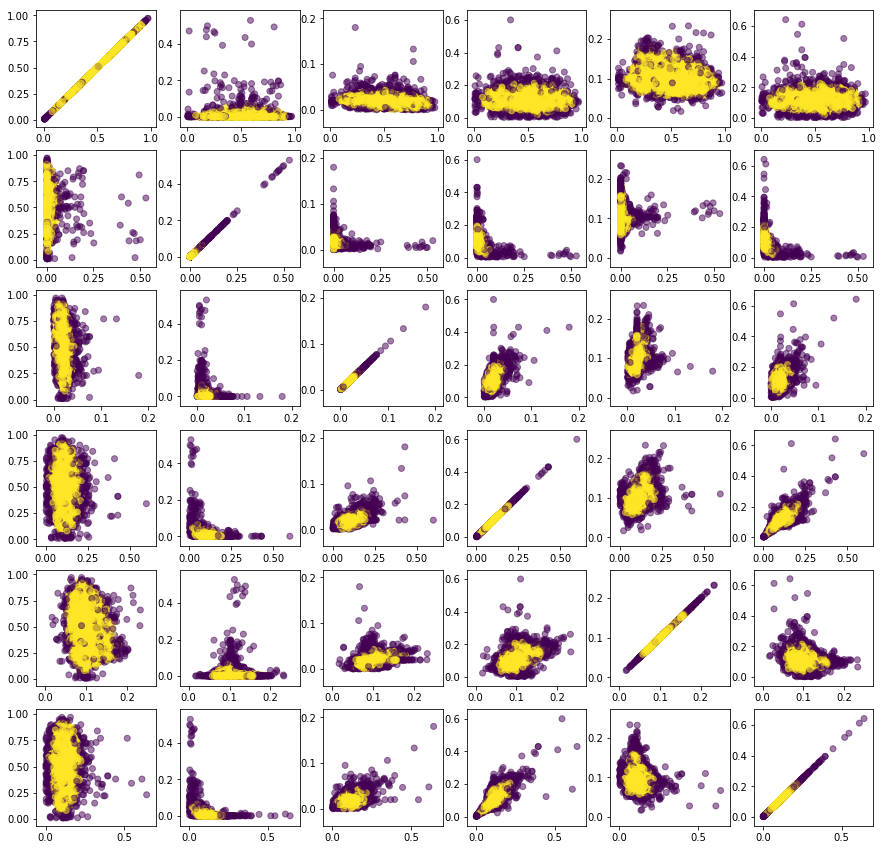

In [274]:
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:,i], X[:, j], c=pred_oc, alpha = 0.5)
#plt.title('Cluster Label based on One Class SVM')
plt.show()

In [136]:
#Isolation Forest

outlier_prop = 0.1

IF = IsolationForest(max_samples = 100, contamination = outlier_prop).fit(X)
pred_if = IF.predict(X)
print(pred_if)
print(np.unique(pred_if))
print(np.mean(pred_if == -1))

[1 1 1 ... 1 1 1]
[-1  1]
0.1


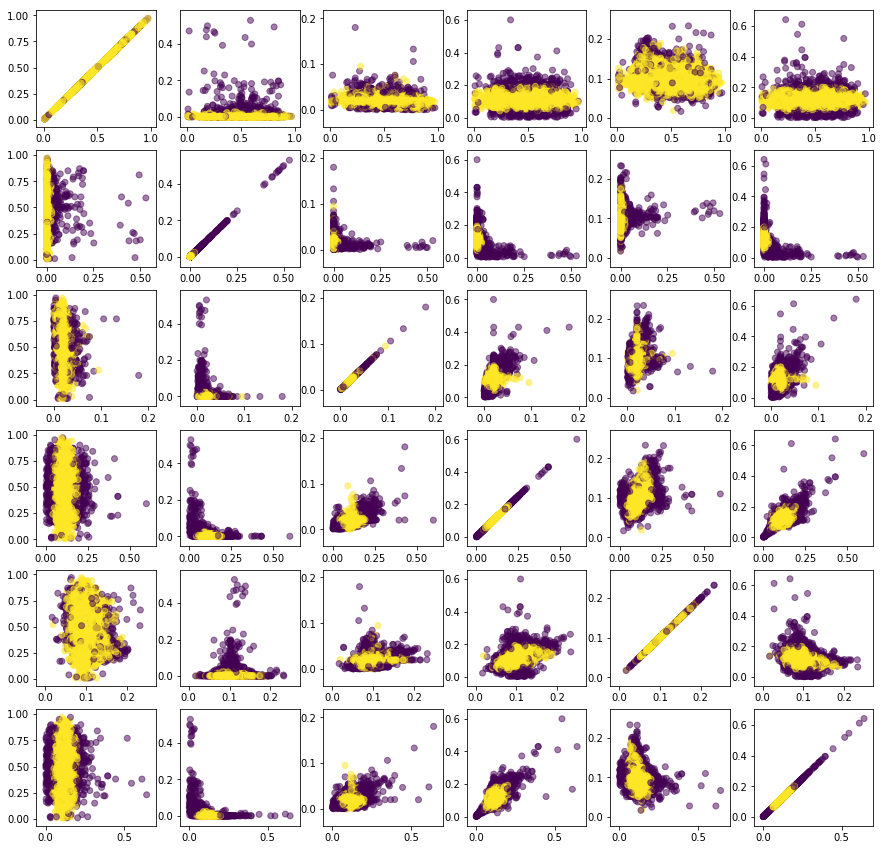

In [197]:
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:,i], X[:, j], c=pred_if, alpha = 0.5)
plt.title('Cluster Label based on Isolation Forest')
plt.show()

Because we don't know the actual proportion of outlier, we're assuming that the outlier/contamination rate is 0.1. Based on the visualizations, it seems hard to tell in 2D based on the predicted labels since the plots amongst the three methods are all similar. However, if I had to choose, I'd think elliptical envelope would perform the best, because a lot of 2D views of the data forms an ellipse. OneClassSVM should do the worst because it does not fit well from rotational symmetry. 

3.2 Use the ground-truth to evaluate the different outlier detection approaches using AUC and
average precision. How can you compare their quality to the clustering approaches from Task
2?

In [281]:
# changing y truth to -1 and 1
y_adjusted = [x if x == 0 else -1 for x in y]
y_adjusted = [x if x == -1 else 1 for x in y_adjusted]

In [282]:
#Elliptic Envelope

#AUC
fpr, tpr, thresholds = roc_curve(y_adjusted, pred_ee, pos_label=1)
print('AUC: ')
print(auc(fpr, tpr))

#Average Precision
print('Average Precision Score:')
print(average_precision_score(y_adjusted, pred_ee))

AUC: 
0.732202995580457
Average Precision Score:
0.9589426257440559


In [283]:
# OneClassSVM

#AUC
fpr, tpr, thresholds = roc_curve(y_adjusted, pred_oc, pos_label=1)


print('AUC: ')
print(auc(fpr, tpr))

#Average Precision
print('Average Precision Score:')
print(average_precision_score(y_adjusted, pred_oc) )

AUC: 
0.5997928444529846
Average Precision Score:
0.939763450519562


In [284]:
#Isolation Forest

#AUC
fpr, tpr, thresholds = roc_curve(y_adjusted, pred_if, pos_label=1)
print('AUC: ')
print(auc(fpr, tpr))

#Average Precision
print('Average Precision Score:')
print(average_precision_score(y_adjusted, pred_if))

AUC: 
0.6644434106331982
Average Precision Score:
0.949028736206954


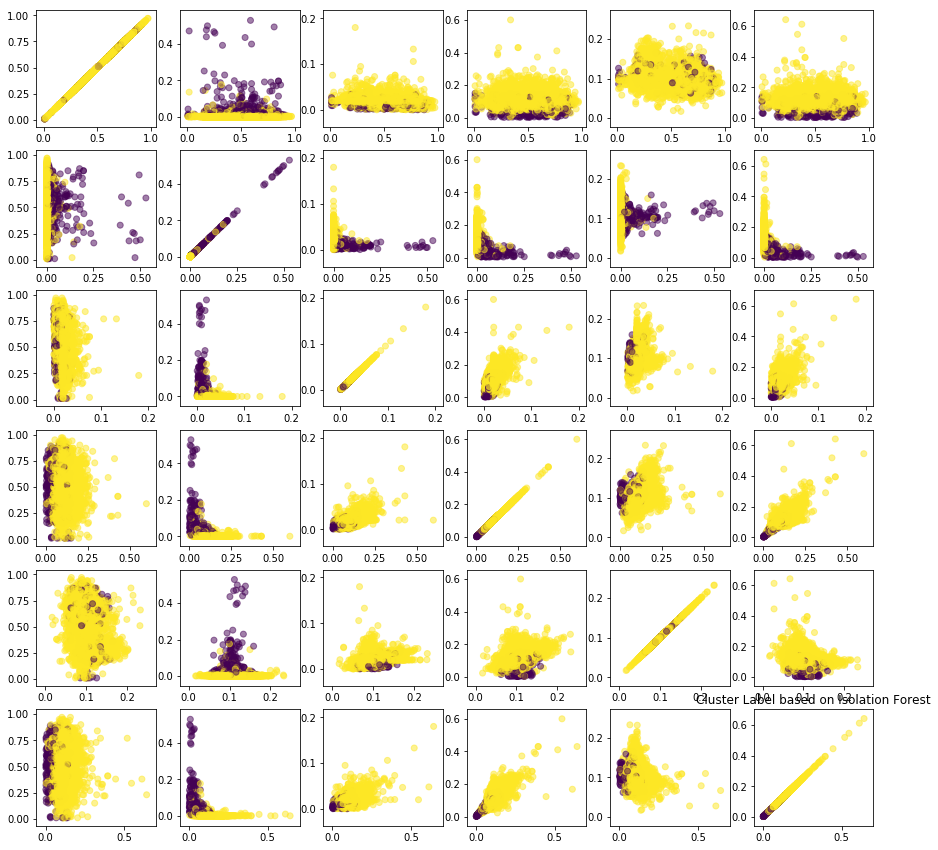

In [277]:
#Truth Labels
fig, axes = plt.subplots(6, 6, figsize = (15, 15))
for i in range(0,6):
    for j in range(0,6):
        axes[i,j].scatter(X[:,i], X[:, j], c=y_adjusted, alpha = 0.5)
plt.title('Cluster Label based on Isolation Forest')
plt.show()

From comparing the ground truth of the data (Plotting the 2D Truth Labels), we can see that the truth and the methods here are much more alike than in task 2. We can compare the quality of the clustering by visualizing the data. For example, the methods in task two tries to physically separate the clusters, so either the boundary for the clusters are smack right in the middle of the data, or the cluster labels are spread out uniformly (because it's already been separated on a different parameter). But if we look at the truth label, it's not apparent how the clusters are linearly separable, which suggests that the way it separates is more complex. Hence, we're using the latter three methods. 